# Payments Fraud Detection using DL

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow import feature_column

from os import getcwd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data=pd.read_csv("FRAUD_DATA.csv")

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Discription of Dataset
###### Step: maps a unit of time in the real world. For example, 1 step is 1 hour of time. Total steps 744 (30 days simulation).
###### Type: cash-in,cash-out,debit, payment and tranfer
###### Amount: Amount of transaction in local currency
###### nameOrig: customer who started transaction
###### oldbalanceOrg: initial balance before transaction
###### newbalanceOrig: balance after transaction
###### nameDest: recipient of transaction
###### isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
###### idFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
data.info(verbose=True,null_counts=True)

C:\Users\titik\AppData\Local\Temp\ipykernel_17216\3406332632.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  data.info(verbose=True,null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.shape

(6362620, 11)

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Text(0.5, 1.0, 'Class Distribution')

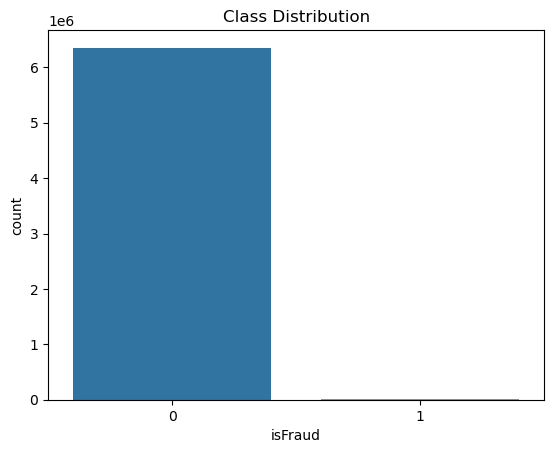

In [8]:
import seaborn as sns
sns.countplot(data=data,x='isFraud')
plt.title('Class Distribution')

Text(0.5, 1.0, 'Distribution of type of transactions')

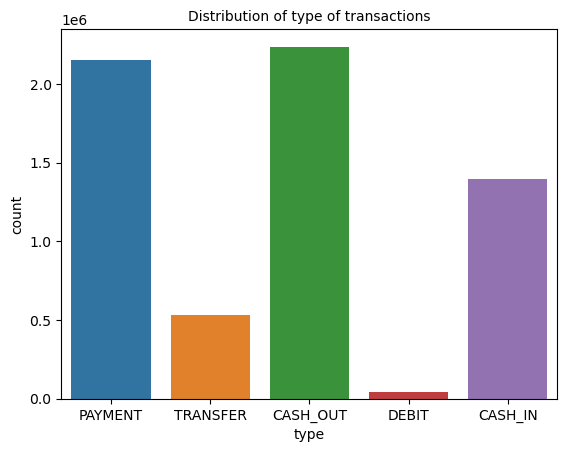

In [9]:
sns.countplot(data=data,x='type')
plt.title('Distribution of type of transactions',fontsize=10)

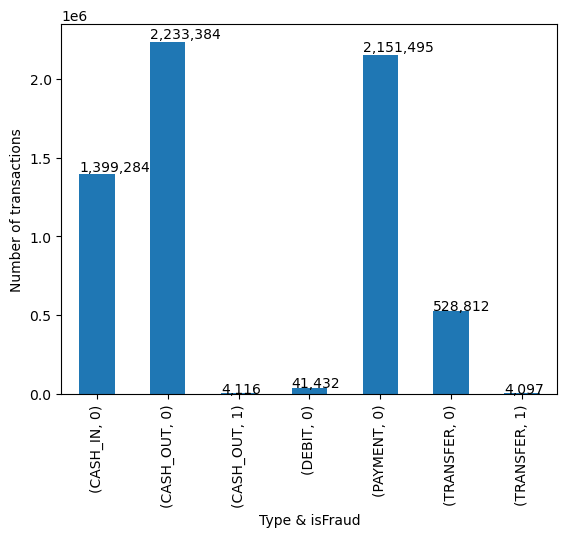

In [10]:
ax=data.groupby(['type','isFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

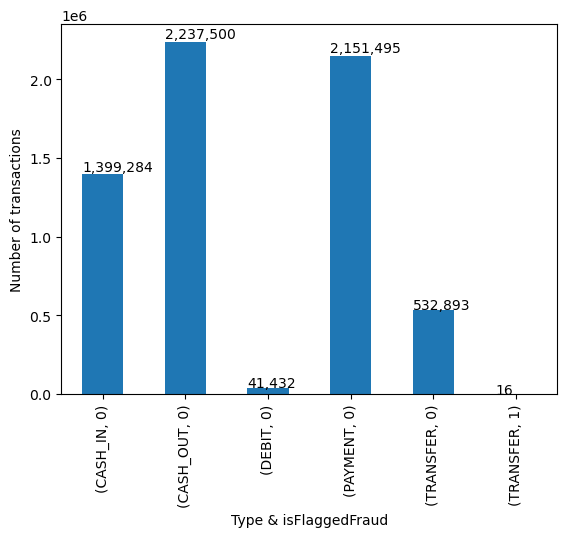

In [11]:
ax=data.groupby(['type','isFlaggedFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFlaggedFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

In [12]:
#categorical data
data.select_dtypes(include='object').columns

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [13]:
#numerical data
data.select_dtypes(include=["int64","float64"]).columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [14]:
# drop not so useful column
data.drop(['nameOrig','nameDest'],axis=1,inplace=True)

In [15]:
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [16]:
data2=pd.get_dummies(data,columns=["type"],prefix=["type"])

In [17]:
data2.corr(numeric_only=False)["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
step              0.031578
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_CASH_IN     -0.019089
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64

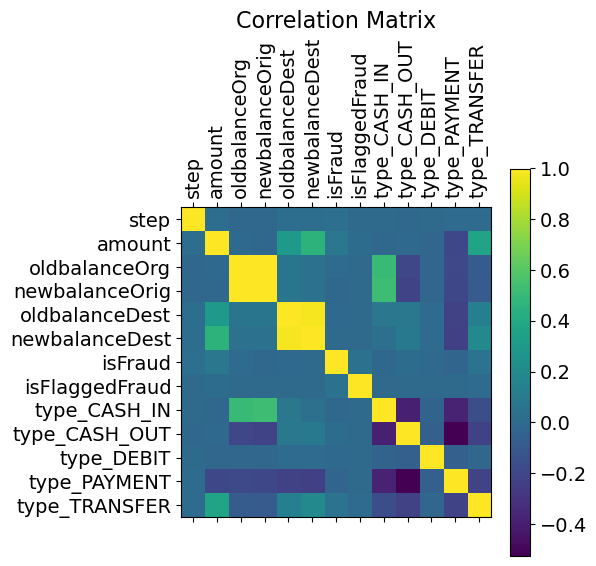

In [18]:
f=plt.figure(figsize=(5,5))
plt.matshow(data2.corr(numeric_only=False),fignum=f.number)
plt.xticks(range(data2.select_dtypes(['number','object']).shape[1]),data2.select_dtypes(['number','object']).columns,fontsize=14,rotation=90)
plt.yticks(range(data2.select_dtypes(['number','object']).shape[1]),data2.select_dtypes(['number','object']).columns,fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix',fontsize=16);

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [20]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
data2[numeric_columns] = scaler.fit_transform(data2[numeric_columns])

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data2, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [22]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

4072076 train examples
1018020 validation examples
1272524 test examples


In [23]:
data2.dtypes

step              float64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud    float64
type_CASH_IN      float64
type_CASH_OUT     float64
type_DEBIT        float64
type_PAYMENT      float64
type_TRANSFER     float64
dtype: object

### Why pipelining before feature extraction:
##### Since the data is non image , some seq. of preocessing steps to prepare and enhance the data before training models
##### Data preprocessing
##### **feature engineering (before feature engineering, pipelining enables the creation of new feature or tranformation of existing ones., its highlightest relevant patterns in data that can enhance model's performance)
##### dimensionality reduction (pipelining can incorporate dimentionality reduction techniques like PCA, to reduce number of featuresnwhile retaining essential information, make computational efficient and prevent overfitting)
##### In summary, pipeling before feature extraction in DL algorithm is a systematic approach to enhance data quality, create meaningful feature, and streanline the overall preprocessing process for better model performance.

In [24]:
#creating an input pipeline using tf.data
def data_to_dataset(dataframe, batch_size=32,shuffle=True):
                    dataframe=dataframe.copy()
                    
                    dataframe['amount']=dataframe['amount'].values.reshape(-1,1)
                    labels=dataframe.pop('isFraud')
                    
                    ds=tf.data.Dataset.from_tensor_slices((dict(dataframe),labels.values))
                    if shuffle:
                        ds=ds.shuffle(buffer_size=len(dataframe))
                    ds=ds.batch(batch_size)
                    return ds

In [25]:
data2.dtypes

step              float64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud    float64
type_CASH_IN      float64
type_CASH_OUT     float64
type_DEBIT        float64
type_PAYMENT      float64
type_TRANSFER     float64
dtype: object

In [26]:
feature_columns = [
    tf.feature_column.numeric_column('step'),
    tf.feature_column.numeric_column('amount'),
    tf.feature_column.numeric_column('oldbalanceOrg'),
    tf.feature_column.numeric_column('newbalanceOrig'),
    tf.feature_column.numeric_column('oldbalanceDest'),
    tf.feature_column.numeric_column('newbalanceDest'),
    tf.feature_column.numeric_column('isFlaggedFraud'),
    tf.feature_column.numeric_column('type_CASH_IN'),
    tf.feature_column.numeric_column('type_CASH_OUT'),
    tf.feature_column.numeric_column('type_DEBIT'),
    tf.feature_column.numeric_column('type_PAYMENT'),
    tf.feature_column.numeric_column('type_TRANSFER')
]
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.



In [27]:
train_ds = data_to_dataset(train, batch_size=32)
val_ds = data_to_dataset(val, batch_size=32)
test_ds = data_to_dataset(test, batch_size=32)

### Creating Model

In [28]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [29]:
## Compiling Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
model.fit(train_ds,validation_data=val_ds,epochs=1)



127253/127253 [==============================] - 2107s 16ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0056 - val_accuracy: 0.9992


In [36]:
import joblib
filename='single_input_neural_network.model'
joblib.dump(model,"single_input_neural_network.model")
loaded_model=joblib.load(filename)

['single_input_neural_network.model']

### Multi-Input Neural Network

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow import feature_column

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("FRAUD_DATA.csv")

# Drop not so useful column
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# One-hot encode categorical data
data = pd.get_dummies(data, columns=["type"], prefix=["type"])

# Normalize numerical features
scaler = MinMaxScaler()
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Split the data into train, validation, and test sets
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# Create an input pipeline using tf.data
def data_to_dataset(dataframe, batch_size=32, shuffle=True):
    dataframe = dataframe.copy()
    dataframe['amount'] = dataframe['amount'].values.reshape(-1, 1)
    labels = dataframe.pop('isFraud')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels.values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Define feature columns
feature_columns = [
    tf.feature_column.numeric_column(feature) for feature in numeric_columns
]

# Create input layers for each feature
input_layers = {
    feature: tf.keras.layers.Input(shape=(1,), name=feature) for feature in numeric_columns
}

# Concatenate the input layers
concatenated = tf.keras.layers.Concatenate()(list(input_layers.values()))

# Create a dictionary of input tensors
input_dict = {feature: input_layers[feature] for feature in numeric_columns}

# Pass the dictionary to DenseFeatures
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)(input_dict)

# Build the neural network
dense1 = layers.Dense(128, activation='relu')(feature_layer)
dense2 = layers.Dense(128, activation='relu')(dense1)
output = layers.Dense(1, activation='sigmoid')(dense2)

# Create the model
model1 = tf.keras.Model(inputs=list(input_layers.values()), outputs=output)

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create datasets
train_ds = data_to_dataset(train, batch_size=32)
val_ds = data_to_dataset(val, batch_size=32)
test_ds = data_to_dataset(test, batch_size=32)
 
# Train the model
model1.fit(train_ds, validation_data=val_ds, epochs=1)

# Evaluate on test set
test_loss, test_accuracy = model1.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy}')


39767/39767 [==============================] - 248s 6ms/step - loss: 0.0035 - accuracy: 0.9993
Test Accuracy: 0.9992833137512207


In [37]:
import joblib
filename='multiple_input_neural_network.model'
joblib.dump(model1,"multiple_input_neural_network.model")
loaded_model1=joblib.load(filename)

['multiple_input_neural_network.model']

### LSTM Model
##### Long short-term memory (LSTM) network is a recurrent neural network (RNN), aimed to deal with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods.

In [38]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("FRAUD_DATA.csv")

# Drop not so useful column
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# One-hot encode categorical data
data = pd.get_dummies(data, columns=["type"], prefix=["type"])

# Normalize numerical features
scaler = MinMaxScaler()
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Split the data into train, validation, and test sets
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# Create an input pipeline using tf.data
def data_to_dataset(dataframe, batch_size=32, shuffle=True):
    dataframe = dataframe.copy()
    dataframe['amount'] = dataframe['amount'].values.reshape(-1, 1)
    labels = dataframe.pop('isFraud')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels.values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Define feature columns
feature_columns = [
    tf.feature_column.numeric_column(feature) for feature in numeric_columns
]

# Create input layers for each feature
input_layers = {
    feature: tf.keras.layers.Input(shape=(1,), name=feature) for feature in numeric_columns
}

# Concatenate the input layers
concatenated = tf.keras.layers.Concatenate()(list(input_layers.values()))

# Create a dictionary of input tensors
input_dict = {feature: input_layers[feature] for feature in numeric_columns}

# Pass the dictionary to DenseFeatures
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)(input_dict)

# LSTM layer
lstm_layer = layers.LSTM(128, activation='tanh', return_sequences=True)(tf.expand_dims(feature_layer, axis=-1))

# Flatten layer
flatten_layer = layers.Flatten()(lstm_layer)

# Output layer
output = layers.Dense(1, activation='sigmoid')(flatten_layer)

# Create the model
model2 = tf.keras.Model(inputs=list(input_layers.values()), outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create datasets
train_ds = data_to_dataset(train, batch_size=32)
val_ds = data_to_dataset(val, batch_size=32)
test_ds = data_to_dataset(test, batch_size=32)

# Train the model
model2.fit(train_ds, validation_data=val_ds, epochs=1)

# Evaluate on test set
test_loss, test_accuracy = model2.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy}')


39767/39767 [==============================] - 3038s 76ms/step - loss: 0.0029 - accuracy: 0.9994
Test Accuracy: 0.9993886351585388


In [39]:
import joblib 
filename='RNN_LSTM.model'
joblib.dump(model2,"RNN_LSTM.model")
loaded_model2=joblib.load(filename)